In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt


In [3]:
## connect to database

from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [4]:
db, conn = pgconnect(credentials)

Connected successfully.


# Task1:

### (1). Given data loading

In [5]:
## read businesstats in and clean data
business_data = pd.read_csv('./data/BusinessStats.csv')

business_data = business_data.drop_duplicates()
business_data = business_data.dropna(axis=0, thresh=5)

In [6]:
conn.execute("DROP TABLE IF EXISTS businessstats")
businessstats_schema = """CREATE TABLE IF NOT EXISTS businessstats (
                         area_id         INT PRIMARY KEY,
                         area_name      VARCHAR(50),
                         number_of_businesses INT,
                         accommodation_and_food_services   INT,
                         retail_trade   INT,
                         agriculture_forestry_and_fishing INT,
                         health_care_and_social_assistance INT,
                         public_administration_and_safety INT,
                         transport_postal_and_warehousing INT
                   )"""
conn.execute(businessstats_schema)
table_name = "businessstats"
business_data.to_sql(table_name, con=conn, if_exists='replace',index=False)
query(conn, "select * from businessstats")

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [7]:
## load 'Neighbourhoods.csv' in and clean data
neighbourhoods_data = pd.read_csv("./data/Neighbourhoods.csv")

neighbourhoods_data = neighbourhoods_data.dropna(axis=0, thresh=5)
neighbourhoods_data = neighbourhoods_data.drop_duplicates()
neighbourhoods_data['population'] = neighbourhoods_data['population'].str.replace(',', '').astype(float)
neighbourhoods_data['number_of_dwellings'] = neighbourhoods_data['number_of_dwellings'].str.replace(',', '').astype(float)

In [8]:
conn.execute("DROP TABLE IF EXISTS neighbourhoods")
neighbourhoods_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods (
                         area_id                        INT PRIMARY KEY,
                         area_name                      VARCHAR(50),
                         land_area                      FLOAT,
                         population                     FLOAT,
                         number_of_dwellings            FLOAT,
                         number_of_businesses           FLOAT,
                         median_annual_household_income FLOAT,
                         avg_monthly_rent               FLOAT,
                         "0-4"                            INT,
                         "5-9"                            INT,
                         "10-14"                          INT,
                         "15-19"                          INT
                   )"""
conn.execute(neighbourhoods_schema)
table_name = "neighbourhoods"
neighbourhoods_data.to_sql(table_name, con=conn, if_exists='replace',index=False)
query(conn, "select * from neighbourhoods")

,Unnamed: 0,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,0-4,5-9,10-14,15-19
0,0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,2325.0,738.0,46996.0,1906.0,467,583,604,560
1,1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,3847.0,907.0,42621.0,1682.0,586,696,661,692
2,2,102011030,Calga - Kulnura,76795.1000,4841.0,1575.0,1102.0,42105.0,1182.0,220,254,304,320
3,3,102011031,Erina - Green Point,3379.3000,14237.0,4450.0,1666.0,43481.0,1595.0,695,778,916,838
4,4,102011032,Gosford - Springfield,1691.2000,19385.0,6373.0,2126.0,45972.0,1382.0,1200,1079,963,977
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,317,106011109,Cessnock Region,1570.4341,7931.0,3281.0,673.0,73164.0,1080.0,432,590,577,527
318,318,106011113,Singleton Region,4067.2349,4919.0,2055.0,698.0,87984.0,1000.0,310,394,353,323
319,319,111021218,Morisset - Cooranbong,330.5208,14959.0,6298.0,1154.0,58084.0,1260.0,813,855,828,962
320,320,114021285,Hill Top - Colo Vale,174.3752,6025.0,2249.0,400.0,81120.0,1512.0,443,500,470,451


Load shape files

In [9]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [10]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

srid = 4283

In [11]:
#Load school catchments:
catchments = gpd.read_file('./data/catchments/catchments_primary.shp')
catchments = catchments.append(gpd.read_file("./data/catchments/catchments_secondary.shp"))
catchments = catchments.append(gpd.read_file("./data/catchments/catchments_future.shp"))
catchments = catchments.drop_duplicates()
catchments = catchments.dropna(axis=0, thresh=14)
catchmentog = catchments.copy()  # creating a copy of the original for later
catchments['geom'] = catchments['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
catchments = catchments.drop(columns="geometry")  # deleting the old copy
catchments.columns = catchments.columns.map(lambda x: x.lower())


In [126]:
conn.execute("""
DROP TABLE IF EXISTS catchments;
CREATE TABLE catchments(
    use_id INT, 
    catch_type VARCHAR(80), 
    use_desc VARCHAR(80), 
    add_date DATE, 
    kindergart TEXT,
    year1      TEXT,
    year2      TEXT,
    year3      TEXT,
    year4      TEXT,
    year5      TEXT,
    year6     TEXT,
    year7     TEXT,
    year8     TEXT,
    year9     TEXT,
    year10    TEXT,
    year11    TEXT,
    year12    TEXT,
    priority  TEXT,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)

catchments.to_sql("catchments", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from catchments")

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,priority,geom
0,2838,PRIMARY,Parklea PS,2018-12-10,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000078...
1,3943,PRIMARY,Gordon WPS,2021-12-19,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB100000010000000103000000010000006F...
2,2404,PRIMARY,Lindfield EPS,2021-12-19,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB10000001000000010300000001000000BE...
3,1839,PRIMARY,Empire Bay PS,2021-11-15,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000032...
4,4393,PRIMARY,Carlingford WPS,2022-02-23,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,0106000020BB1000000100000001030000000100000065...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140,8524,HIGH_COED,Karabar HS,2022-03-05,0,0,0,0,0,0,0,2023,2023,2023,2023,2023,2023,None,0106000020BB100000010000000103000000010000006E...
2141,4680,PRIMARY,Googong PS,2022-03-05,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB1000000100000001030000000100000072...
2142,2540,PRIMARY,Michelago PS,2022-03-05,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,None,0106000020BB10000001000000010300000001000000BF...
2143,8922,HIGH_COED,Jerrabomberra HS,2022-03-05,0,0,0,0,0,0,0,2023,2023,0,0,0,0,None,0106000020BB1000000100000001030000000100000020...


In [ ]:
## Clean and load 'breakEnterDewlling.csv'
break_enter_dwelling = gpd.read_file('./data/break/BreakEnterDwelling_JanToDec2021.shp')
break_enter_dwelling = break_enter_dwelling.drop_duplicates()
break_enter_dwelling = break_enter_dwelling.dropna()

a = break_enter_dwelling.copy()
break_enter_dwellingCpy = a.rename(columns=str.lower)
break_enter_dwellingCpy.dropna(axis=0, thresh=5)

break_enter_dwellingCpy['shape_leng'] = break_enter_dwellingCpy['shape_leng'] * 1000
break_enter_dwellingCpy['shape_area'] = break_enter_dwellingCpy['shape_area'] * 1000000
break_enter_dwellingCpy['geom'] = break_enter_dwellingCpy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
break_enter_dwellingCpy = break_enter_dwellingCpy.drop(columns="geometry")

In [128]:
conn.execute("""
DROP TABLE IF EXISTS break_enter_dwelling;
CREATE TABLE break_enter_dwelling (
    objectid INT PRIMARY KEY, 
    contour float, 
    density VARCHAR(50), 
    orig_fid INT, 
    shape_leng FLOAT,
    shape_area  FLOAT,
    geom GEOMETRY(MULTIPOLYGON,4283)
);"""
)

break_enter_dwellingCpy.to_sql("break_enter_dwelling", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from break_enter_dwelling")

,objectid,contour,density,orig_fid,shape_leng,shape_area,geom
0,1,8.0,Low Density,1,12.137757,5.811009,0106000020BB1000000100000001030000000100000015...
1,2,8.0,Low Density,1,19.106003,14.905408,0106000020BB100000010000000103000000010000001D...
2,3,8.0,Low Density,1,6.067900,2.020688,0106000020BB1000000100000001030000000100000007...
3,4,8.0,Low Density,1,11.005890,6.306408,0106000020BB100000010000000103000000010000000E...
4,5,8.0,Low Density,1,8.073184,3.019542,0106000020BB100000010000000103000000010000000F...
...,...,...,...,...,...,...,...
2589,2590,10.0,High Density,3,15.358155,11.013172,0106000020BB1000000100000001030000000100000016...
2590,2591,10.0,High Density,3,28.327238,28.698929,0106000020BB1000000100000001030000000100000028...
2591,2592,10.0,High Density,3,6.653517,2.289647,0106000020BB1000000100000001030000000100000009...
2592,2593,10.0,High Density,3,47.098443,44.316193,0106000020BB100000010000000103000000010000004D...


In [15]:
## Clean and load SA2 file
sa2 = gpd.read_file('./data/sa2/SA2_2016_AUST.shp')
sa2 = sa2.drop_duplicates()
sa2 = sa2.dropna(0)
sa2.columns = sa2.columns.map(lambda x: x.lower())
sa2_2016_aust = sa2.copy()  # creating a copy of the original for later
sa2_2016_aust['geom'] = sa2_2016_aust['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_2016_aust = sa2_2016_aust.drop(columns="geometry")  # deleting the old column

In [127]:
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")
sa2_2016_aust_schema = '''CREATE TABLE sa2_2016_aust (
                     sa2_main16 INT PRIMARY KEY,
                     sa2_5dig16 INT,
                     sa2_name16  TEXT,
                     sa3_code16 INT,
                     sa3_name16 TEXT,
                     sa4_code16 INT,
                     sa4_name16 TEXT,
                     gcc_code16 VARCHAR,
                     gcc_name16 TEXT,
                     ste_code16 INT,
                     ste_name16 TEXT,
                     areasqkm16 NUMERIC,
                     geom GEOMETRY(MULTIPOLYGON, 4283)
                     )''' 
conn.execute(sa2_2016_aust_schema)
sa2_2016_aust.to_sql("sa2_2016_aust", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from sa2_2016_aust")
# foreign key(sa2_main16) references neighbourhoods(area_id) 

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,0106000020BB100000010000000103000000010000005F...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,0106000020BB100000010000000103000000010000002C...
2,101031016,11016,Jindabyne - Berridale,10103,Snowy Mountains,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3939.5484,0106000020BB100000010000000103000000010000005F...
3,101041017,11017,Batemans Bay,10104,South Coast,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,63.7074,0106000020BB1000000100000001030000000100000036...
4,101041018,11018,Batemans Bay - South,10104,South Coast,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,30.5948,0106000020BB100000070000000103000000010000001C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,0106000020BB100000010000000103000000010000000C...
2288,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,0106000020BB1000000100000001030000000100000094...
2289,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,0106000020BB100000380000000103000000010000000E...
2290,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,0106000020BB1000000300000001030000000100000017...


### Own datasets

In [17]:
## Extra data1: playground.geojason
playGround = gpd.read_file("./data/Playgrounds.geojson")
playGround.drop_duplicates()

playGround['geom'] = playGround['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
playGround = playGround.drop(columns="geometry")
a = playGround.copy()
playGroundCpy = a.rename(columns=str.lower)


In [18]:
conn.execute("""
DROP TABLE IF EXISTS playground;
CREATE TABLE playground (
    objectid INTEGER PRIMARY KEY, 
    name VARCHAR(80),
    type VARCHAR(50),
    geom GEOMETRY(POINT,4283)
);"""
)

playGroundCpy.to_sql('playground', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
query(conn, "select * from playground")

,objectid,name,type,geom
0,1,McKell Playground B,Playground,0101000020BB1000006B9083994BE662401116419B28F3...
1,2,Minogue Crescent Reserve Playground,Playground,0101000020BB1000006E221BE4A8E56240BC32B4D4B0F0...
2,3,May Pitt Playground,Playground,0101000020BB100000EB9B6535D0E56240E2D30CDE23F1...
3,4,Clyne Reserve Playground,Playground,0101000020BB1000002CCBB99A74E6624085C4981BB0ED...
4,5,Shannon Reserve Playground,Playground,0101000020BB100000FBCD040EDBE662405B122F7C61F1...
...,...,...,...,...
146,4562,Redfern Park Playground C,Playground,0101000020BB1000006013D8149DE6624048B2744394F2...
147,5762,Frances Newton Playground,Playground,0101000020BB1000009E545B07F1E66240F850204547F0...
148,6966,Turruwul Park Playground,Playground,0101000020BB100000835784E18BE66240C840BA8793F5...
149,7366,Waterloo Park & Mount Carmel Fitness Station,Fitness station,0101000020BB100000F81F081E8BE662408559CD2427F3...


In [19]:
## Extra data2: robbery.shp
robbery = gpd.read_file('./data/robbery/Robbery_JanToDec2021.shp')
robbery = robbery.drop_duplicates()
robbery = robbery.dropna(0)
robbery.columns = robbery.columns.map(lambda x: x.lower())
robberyCpy = robbery.copy()  # creating a copy of the original for later
robberyCpy['shape_leng'] = robberyCpy['shape_leng'] * 1000
robberyCpy['shape_area'] = robberyCpy['shape_area'] * 1000000
robberyCpy['geom'] = robberyCpy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
robberyCpy = robberyCpy.drop(columns="geometry") 

In [20]:
conn.execute("DROP TABLE IF EXISTS robbery")
robbery_schema = '''CREATE TABLE robbery (
                     objectid INT PRIMARY KEY,
                     contour FLOAT,
                     density  TEXT,
                     orig_fid INT,
                     shape_leng FLOAT,
                     shape_area FLOAT,
                     geom GEOMETRY(MULTIPOLYGON, 4283)
                     )''' 
conn.execute(robbery_schema)
robberyCpy.to_sql("robbery", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from robbery")

,objectid,contour,density,orig_fid,shape_leng,shape_area,geom
0,1,8.0,Low Density,1,18.407142,25.021620,0106000020BB1000000100000001030000000100000024...
1,2,8.0,Low Density,1,11.174742,5.257936,0106000020BB1000000100000001030000000100000012...
2,3,8.0,Low Density,1,10.063867,5.258694,0106000020BB100000010000000103000000010000000D...
3,4,8.0,Low Density,1,12.074495,5.507265,0106000020BB1000000100000001030000000100000016...
4,5,8.0,Low Density,1,26.037953,37.427693,0106000020BB1000000100000001030000000100000037...
...,...,...,...,...,...,...,...
1832,1833,10.0,High Density,3,8.834382,2.761737,0106000020BB100000010000000103000000010000000D...
1833,1834,10.0,High Density,3,39.600600,54.545266,0106000020BB1000000100000001030000000100000038...
1834,1835,10.0,High Density,3,18.188628,7.579800,0106000020BB100000010000000103000000010000001F...
1835,1836,10.0,High Density,3,11.515608,5.733150,0106000020BB1000000100000001030000000100000012...


### (2). Datasets integration and measure calculation

In [21]:
## Join neighbourhoods, businesstats and sa2 by using area_id
nei_business_sa2 = pd.read_sql_query("""
            Select N.area_id, N.area_name, N.land_area, N.population, (B.health_care_and_social_assistance) as health, (B.accommodation_and_food_services) as accom, B.retail_trade as retail, (N.median_annual_household_income) as median_income, (N.avg_monthly_rent) as median_rent, (N."0-4" +N."5-9" + N."10-14" + N."15-19") as young_people, S.geom 
            From neighbourhoods N 
            left JOIN businessstats B ON (N.area_id = B.area_id)
            left JOIN sa2_2016_aust S on (N.area_id = S.sa2_main16) 
           
""",conn)
nei_business_sa2 = nei_business_sa2[~ nei_business_sa2['young_people'].isin([0])].dropna(axis=0)
conn.execute("""DROP TABLE IF EXISTS nei_business_sa2 """, conn)
nei_business_sa2.to_sql('nei_business_sa2', conn, if_exists='append', index=False,dtype={'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, "select * from nei_business_sa2")

,area_id,area_name,land_area,population,health,accom,retail,median_income,median_rent,young_people,geom
0,101051540,Goulburn Region,9035.1221,12670.0,33,38,52,62712.0,800.0,3090,0106000020BB10000001000000010300000002000000C0...
1,102011028,Avoca Beach - Copacabana,643.8000,7590.0,60,33,35,46996.0,1906.0,2214,0106000020BB100000010000000103000000010000005E...
2,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,43,23,45,42621.0,1682.0,2635,0106000020BB1000000100000001030000000100000000...
3,102011030,Calga - Kulnura,76795.1000,4841.0,12,14,43,42105.0,1182.0,1098,0106000020BB1000000200000001030000000100000085...
4,102011031,Erina - Green Point,3379.3000,14237.0,179,68,145,43481.0,1595.0,3227,0106000020BB1000000100000001030000000100000041...
...,...,...,...,...,...,...,...,...,...,...,...
304,128011529,Gymea - Grays Point,579.8000,18057.0,87,39,77,52871.0,2113.0,4786,0106000020BB1000000100000001030000000100000092...
305,128011530,Miranda - Yowie Bay,599.7000,18975.0,230,86,150,50319.0,1879.0,4542,0106000020BB1000000100000001030000000100000046...
306,128011531,Sylvania - Taren Point,607.3000,16733.0,75,91,151,47383.0,2059.0,3834,0106000020BB10000001000000010300000001000000F3...
307,128021608,Loftus - Yarrawarrah,384.4000,7426.0,25,9,20,51243.0,2163.0,2054,0106000020BB10000001000000010300000001000000A1...


#### create index

Before join tables, we gonna create three spital index to speed up spital data integration.

In [22]:
index_command = "CREATE INDEX sa2_idx ON nei_business_sa2 USING GIST(geom)"
conn.execute("DROP INDEX IF ExISTS sa2_idx ")
conn.execute(index_command)

In [23]:
index_command = "CREATE INDEX catch_idx ON catchments USING GIST (geom)"
conn.execute("DROP INDEX IF ExISTS catch_idx ")
conn.execute(index_command)

In [24]:
index_command = "CREATE INDEX break_idx ON break_enter_dwelling USING GIST (geom)"
conn.execute("DROP INDEX IF ExISTS break_idx ")
conn.execute(index_command)

#### Spatial join and measurements calculation

spatial join nei_business_sa2 with catchments and calculate school measure

In [25]:
## spatial join nei_business_sa2 with catchments and calculate school measure

command = """
            SELECT N.area_id, N.area_name, count(use_id) as num_catchments, young_people
            FROM nei_business_sa2 N JOIN catchments C ON ST_Intersects(N.geom, C.geom)
            Group by N.area_id, N.area_name, young_people
            
"""
nei_catchments = pd.read_sql_query(command, conn)
nei_catchments

,area_id,area_name,num_catchments,young_people
0,101051540,Goulburn Region,39,3090
1,102011028,Avoca Beach - Copacabana,6,2214
2,102011029,Box Head - MacMasters Beach,8,2635
3,102011030,Calga - Kulnura,27,1098
4,102011031,Erina - Green Point,17,3227
...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,16,6210
305,128021538,Sutherland - Kirrawee,17,4894
306,128021607,Engadine,13,5176
307,128021608,Loftus - Yarrawarrah,8,2054


In [26]:
school_measure = pd.DataFrame({
    "area_id": nei_catchments['area_id'],
    "school_measure": nei_catchments['num_catchments'] / nei_catchments['young_people'] * 1000 
})
school_measure

,area_id,school_measure
0,101051540,12.621359
1,102011028,2.710027
2,102011029,3.036053
3,102011030,24.590164
4,102011031,5.268051
...,...,...
304,128021536,2.576490
305,128021538,3.473641
306,128021607,2.511592
307,128021608,3.894839


In [27]:
## spatial join nei_business_sa2 with break_enter_dwelling in order to calculate crime_measurements
command = """
            SELECT N.area_id, N.area_name,(sum(shape_area)/ land_area) as crime_measure
            FROM nei_business_sa2 N
            JOIN break_enter_dwelling B ON ST_Intersects(N.geom, B.geom)
            where density = 'High Density'
            group by N.area_id, N.area_name,N.land_area
            
"""
nei_dwelling = pd.read_sql_query(command, conn) 
nei_dwelling

,area_id,area_name,crime_measure
0,102011032,Gosford - Springfield,0.103812
1,102011036,Niagara Park - Lisarow,0.002031
2,102011039,Terrigal - North Avoca,0.019703
3,102011040,Umina - Booker Bay - Patonga,0.024472
4,102011041,Wamberal - Forresters Beach,0.014335
...,...,...,...
190,128011529,Gymea - Grays Point,0.020661
191,128011531,Sylvania - Taren Point,0.035016
192,128011602,Caringbah,0.240459
193,128011603,Caringbah South,0.236087


In [28]:
accom_retail_health = pd.read_sql_query("""
    SELECT N.area_id,(sum(accom)/N.population * 1000) as accom_measure, (sum(retail)/ N.population *1000) as retail_measure, (sum(health)/N.population*1000) as health_measure
    FROM nei_business_sa2 N LEFT outer join nei_catchments C on (N.area_id = C.area_id)
    left outer JOIN nei_dwelling D on (N.area_id = D.area_id)
    group by N.area_id, N.population
""", conn)
accom_retail_health

,area_id,accom_measure,retail_measure,health_measure
0,125031479,47.840532,161.921799,89.547662
1,124011453,6.972893,13.945786,14.294430
2,128021533,5.993407,11.986815,5.394067
3,118011339,33.874938,45.691777,68.143772
4,128021609,4.346645,13.039935,11.953274
...,...,...,...,...
304,127031523,14.730364,33.900015,16.546436
305,122021422,16.648726,33.010405,28.991747
306,119021364,65.368292,94.561898,75.522589
307,118021348,15.723611,16.300624,33.034008


In [29]:
measures = pd.merge(nei_dwelling,school_measure,how='inner',on='area_id')
measures = pd.merge(measures,accom_retail_health,how='inner',on='area_id')
measures

,area_id,area_name,crime_measure,school_measure,accom_measure,retail_measure,health_measure
0,102011032,Gosford - Springfield,0.103812,3.318322,77.585762,137.838535,203.043590
1,102011036,Niagara Park - Lisarow,0.002031,5.099873,12.724826,18.597822,22.513153
2,102011039,Terrigal - North Avoca,0.019703,2.368967,80.865604,89.977221,185.649203
3,102011040,Umina - Booker Bay - Patonga,0.024472,0.951656,23.091831,20.452765,20.782648
4,102011041,Wamberal - Forresters Beach,0.014335,4.168114,24.058983,32.596042,67.520373
...,...,...,...,...,...,...,...
190,128011529,Gymea - Grays Point,0.020661,2.089427,17.278618,34.114194,38.544609
191,128011531,Sylvania - Taren Point,0.035016,3.129890,87.013686,144.385346,71.714576
192,128011602,Caringbah,0.240459,3.508772,53.600258,94.930578,67.807556
193,128011603,Caringbah South,0.236087,2.035475,9.545021,41.998091,46.452434


### Task2: Greater Sydney liveability Analysis

### 1. z_score

In [30]:
import numpy as np
def z(measure,x):
    return (x-(sum(measure)/len(measure)))/ np.std(measure)

In [31]:
measures.dtypes

area_id             int64
area_name          object
crime_measure     float64
school_measure    float64
accom_measure     float64
retail_measure    float64
health_measure    float64
dtype: object

In [103]:
measures['z_school'] = 1
measures['z_accom'] = 1
measures['z_retail'] = 1
measures['z_health'] = 1
measures['z_crime'] = 1


i = 0
while i < len(measures['z_school']):
    measures['z_school'][i] = z(measures['school_measure'], measures['school_measure'][i])
    i +=1
    
i = 0
while i < len(measures['z_accom']):
    measures['z_accom'][i] = z(measures['accom_measure'], measures['accom_measure'][i] )
    i +=1
   
i = 0
while i < len(measures['z_retail']):
    measures['z_retail'][i] = z(measures['retail_measure'], measures['retail_measure'][i])
    i +=1 
    
i = 0
while i < len(measures['z_health']):
    measures['z_health'][i] = z(measures['health_measure'], measures['health_measure'][i])
    i +=1 
    
i = 0
while i < len(measures['z_crime']):
    measures['z_crime'][i] = z(measures['crime_measure'], measures['crime_measure'][i])
    i +=1 


measures

/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/o

,area_id,area_name,crime_measure,school_measure,accom_measure,retail_measure,health_measure,z_school,z_accom,z_retail,z_health,z_crime,liveability_score
0,102011032,Gosford - Springfield,0.103812,3.318322,77.585762,137.838535,203.043590,0,0,0,0,0,0.500000
1,102011036,Niagara Park - Lisarow,0.002031,5.099873,12.724826,18.597822,22.513153,0,0,0,0,0,0.500000
2,102011039,Terrigal - North Avoca,0.019703,2.368967,80.865604,89.977221,185.649203,0,0,0,0,0,0.500000
3,102011040,Umina - Booker Bay - Patonga,0.024472,0.951656,23.091831,20.452765,20.782648,-1,0,0,0,0,0.268941
4,102011041,Wamberal - Forresters Beach,0.014335,4.168114,24.058983,32.596042,67.520373,0,0,0,0,0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,128011529,Gymea - Grays Point,0.020661,2.089427,17.278618,34.114194,38.544609,0,0,0,0,0,0.500000
191,128011531,Sylvania - Taren Point,0.035016,3.129890,87.013686,144.385346,71.714576,0,0,0,0,0,0.500000
192,128011602,Caringbah,0.240459,3.508772,53.600258,94.930578,67.807556,0,0,0,0,0,0.500000
193,128011603,Caringbah South,0.236087,2.035475,9.545021,41.998091,46.452434,0,0,0,0,0,0.500000


### Greater Sydney liveability score

In [33]:
## Greater Sydney liveability score
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s
socres = measures['z_school'] + measures['z_accom'] + measures['z_retail']  + measures['z_health'] - measures['z_crime']

live_score = sigmoid(socres)
measures['liveability_score'] = live_score


In [106]:
## Make a table for liveability_score

sa2['sa2_main16'] = sa2['sa2_main16'].astype(int)
helper_df = pd.merge(measures, sa2, left_on='area_id', right_on ='sa2_main16')

liveability_score = pd.DataFrame({
    "area_id": measures['area_id'],
    "area_name":measures['area_name'],
    "liveability_score": measures['liveability_score'],
    "geom": helper_df['geometry']
})

## sorting all areas by using score.
liveability_score.sort_values(by = 'liveability_score', ascending = False)

,area_id,area_name,liveability_score,geom
51,117031337,Sydney - Haymarket - The Rocks,1.000000,"MULTIPOLYGON (((151.22538 -33.85527, 151.22524..."
23,116011303,Blacktown (East) - Kings Park,0.999983,"POLYGON ((150.90492 -33.76011, 150.90490 -33.7..."
112,121011401,St Leonards - Naremburn,0.999877,"POLYGON ((151.17861 -33.81633, 151.17852 -33.8..."
101,120031391,Burwood - Croydon,0.999877,"POLYGON ((151.09848 -33.87134, 151.09849 -33.8..."
55,118011343,Double Bay - Bellevue Hill,0.999089,"POLYGON ((151.23260 -33.87480, 151.23272 -33.8..."
...,...,...,...,...
58,118011346,Rose Bay - Vaucluse - Watsons Bay,0.268941,"MULTIPOLYGON (((151.27049 -33.84792, 151.27045..."
47,117031333,Potts Point - Woolloomooloo,0.119203,"POLYGON ((151.21886 -33.86862, 151.21897 -33.8..."
61,118021564,Kensington (NSW),0.119203,"POLYGON ((151.22328 -33.90464, 151.22354 -33.9..."
45,117031331,Glebe - Forest Lodge,0.119203,"POLYGON ((151.18276 -33.87221, 151.18289 -33.8..."


Text(0.5, 1, 'Liveability Score by Greater Sydney Areas')

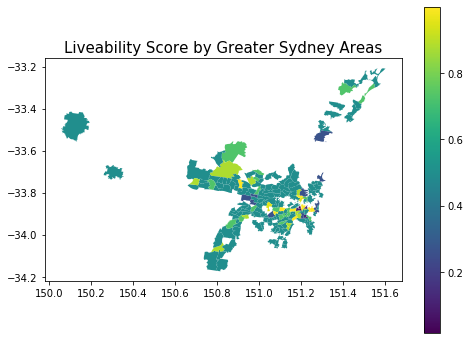

In [35]:
great = gpd.read_postgis("SELECT area_id, geom FROM nei_business_sa2", conn)
live_geod = gpd.GeoDataFrame(liveability_score, geometry = 'geom')

da_merge = great.merge(live_geod, on = 'area_id', how = 'left')
da_merge = da_merge.drop(['geom_x'],axis =1 )

a = gpd.GeoDataFrame(da_merge, geometry='geom_y')
a.plot('liveability_score', figsize=(8, 6), legend = True)
plt.title('Liveability Score by Greater Sydney Areas', fontsize=15)

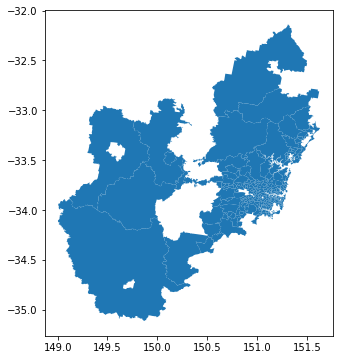

In [37]:
## Map for neighbourhoods area
great = gpd.read_postgis("SELECT area_name, geom FROM nei_business_sa2", conn)
great = great.plot(figsize=(8, 6))


### correlation test

#### a. correlation between score and the median rent

In [38]:
rent_income = pd.DataFrame({
    "area_id": nei_business_sa2['area_id'],
    "median_rent": nei_business_sa2['median_rent'],
    "median_income": nei_business_sa2['median_income']
})

data = pd.merge(liveability_score, rent_income, how='left', on='area_id')

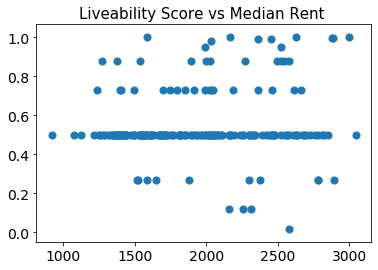

Pearsonr correlation =  0.113，p value =  0.117


In [39]:
import scipy.stats as stats

x_value = data['median_rent']
y_value = live_score
plt.scatter(x_value, y_value, s=50)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Liveability Score vs Median Rent ', fontsize=15)
plt.show()

r,p = stats.pearsonr(x_value, y_value)
print('Pearsonr correlation = %6.3f，p value = %6.3f'%(r,p))


No relations exit between scores and median rent, sine p_value > 0.05 and it is hard to find any relations from plotted diagram.

#### b. correlation between score and the median income

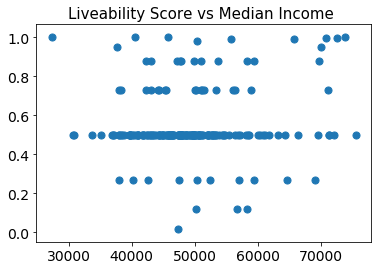

Pearsonr correlation =  0.103，p value =  0.151


In [40]:
import scipy.stats as stats

x_value = data['median_income']
y_value = live_score
plt.scatter(x_value, y_value, s=50)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Liveability Score vs Median Income ', fontsize=15)

plt.show()

r,p = stats.pearsonr(x_value, y_value)
print('Pearsonr correlation = %6.3f，p value = %6.3f'%(r,p))

No relation exit between median income and socre. Since we can not find relations in the diagram and p_value > 0.05

## Task3: City of Sydney Analysis

Stakeholders：families with younger children. Liveability Score= S(z(school)+z(playground) -z(robbery) -z(crime))


In [41]:
### Measures: playground_measure, density of play_ground

command = """
            SELECT sa3_code16, count(objectid) as num_playground
            FROM sa2_2016_aust S
            JOIN playground P ON ST_Contains(S.geom, P.geom)
            where P.type = 'Playground'
            group by sa3_code16
            
"""
p = pd.read_sql_query(command, conn)
p

,sa3_code16,num_playground
0,11703,129
1,11801,1
2,12002,2


In [58]:
ply_measures = pd.DataFrame({
    "sa3_code16": p['sa3_code16'],
    "playGround_measure" : p['num_playground'] / sum( p['num_playground'] )
})
ply_measures

,sa3_code16,playGround_measure
0,11703,0.977273
1,11801,0.007576
2,12002,0.015152


In [43]:
## robbery_measure，hostspot area/ total area

command = """
            SELECT sa3_code16,(sum(shape_area) /1000000/ ST_area(S.geom)) as robbery_measure
            FROM sa2_2016_aust S
            JOIN robbery R ON ST_Intersects(S.geom, R.geom)
            where density = 'High Density'
            group by sa3_code16,S.geom
            
"""
robbery_measure = pd.read_sql_query(command, conn)
robbery_measure

,sa3_code16,robbery_measure
0,10102,0.025731
1,10104,0.000285
2,10104,0.000405
3,10104,0.000706
4,10105,0.001043
...,...,...
188,12703,0.264414
189,12703,0.027461
190,12801,0.000799
191,12801,0.010030


In [81]:
## school_cathchments_measures density

command = """
            SELECT sa3_code16,sa3_name16, count(use_id) as num_catchments
            FROM sa2_2016_aust S
            JOIN catchments C ON ST_Intersects(S.geom, C.geom)
            Group by sa3_code16, sa3_name16
            
"""
city_catchments = pd.read_sql_query(command, conn)
city_catchments

,sa3_code16,sa3_name16,num_catchments
0,10102,Queanbeyan,87
1,10103,Snowy Mountains,54
2,10104,South Coast,92
3,10105,Goulburn - Mulwaree,49
4,10106,Young - Yass,70
...,...,...,...
109,80103,Canberra East,18
110,80104,Gungahlin,12
111,80107,Tuggeranong,6
112,80111,Urriarra - Namadgi,12


In [84]:
c_catchments = pd.DataFrame({
    "sa3_code16": city_catchments['sa3_code16'],
    "area_name": city_catchments['sa3_name16'],
    "catchments_measure" : city_catchments['num_catchments'] / sum(city_catchments['num_catchments'])
})
c_catchments

,sa3_code16,area_name,catchments_measure
0,10102,Queanbeyan,0.010906
1,10103,Snowy Mountains,0.006769
2,10104,South Coast,0.011533
3,10105,Goulburn - Mulwaree,0.006143
4,10106,Young - Yass,0.008775
...,...,...,...
109,80103,Canberra East,0.002256
110,80104,Gungahlin,0.001504
111,80107,Tuggeranong,0.000752
112,80111,Urriarra - Namadgi,0.001504


In [48]:
command = """
            SELECT sa3_code16,(sum(shape_area) /1000000/ ST_area(S.geom)) as crime_measure
            FROM sa2_2016_aust S
            JOIN break_enter_dwelling B ON ST_Intersects(S.geom, B.geom)
            where density = 'High Density'
            group by sa3_code16,S.geom
            
"""
c_crime_measure = pd.read_sql_query(command, conn)
c_crime_measure

,sa3_code16,crime_measure
0,10102,0.015775
1,10102,0.082445
2,10102,0.042970
3,10102,0.113552
4,10104,0.000353
...,...,...
327,12801,0.241818
328,12801,0.246363
329,12801,0.021163
330,12802,0.090740


In [85]:
## combines all measures in one table

city_measures = pd.merge(robbery_measure,ply_measures, on='sa3_code16')
city_measures = pd.merge(city_measures,c_catchments, on='sa3_code16')
city_measures = pd.merge(city_measures,c_crime_measure, on='sa3_code16')

city_measures

,sa3_code16,robbery_measure,playGround_measure,area_name,catchments_measure,crime_measure
0,11703,1.571658,0.977273,Sydney Inner City,0.017550,2.925380
1,11703,1.571658,0.977273,Sydney Inner City,0.017550,2.924692
2,11703,1.571658,0.977273,Sydney Inner City,0.017550,4.553240
3,11703,1.571658,0.977273,Sydney Inner City,0.017550,3.680610
4,11703,1.571658,0.977273,Sydney Inner City,0.017550,5.583777
...,...,...,...,...,...,...
112,11801,0.150651,0.007576,Eastern Suburbs - North,0.011282,0.120942
113,11801,0.150651,0.007576,Eastern Suburbs - North,0.011282,0.617402
114,12002,0.238575,0.015152,Leichhardt,0.005140,2.406424
115,12002,0.238575,0.015152,Leichhardt,0.005140,0.019407


In [88]:
city_measures['z_school'] = 1
city_measures['z_ply'] = 1
city_measures['z_robbery'] = 1
# city_measures['z_health'] = 1
city_measures['z_crime'] = 1


i = 0
while i < len(city_measures['z_school']):
    city_measures['z_school'][i] = z(city_measures['catchments_measure'], city_measures['catchments_measure'][i])
    i +=1
    
i = 0
while i < len(city_measures['z_ply']):
    city_measures['z_ply'][i] = z(city_measures['playGround_measure'], city_measures['playGround_measure'][i] )
    i +=1
   
i = 0
while i < len(city_measures['z_robbery']):
    city_measures['z_robbery'][i] = z(city_measures['robbery_measure'], city_measures['robbery_measure'][i])
    i +=1 
    
# i = 0
# while i < len(city_measures['z_health']):
#     city_measures['z_health'][i] = z(city_measures['health_measure'], city_measures['health_measure'][i])
#     i +=1 
    
i = 0
while i < len(city_measures['z_crime']):
    city_measures['z_crime'][i] = z(city_measures['crime_measure'], city_measures['crime_measure'][i])
    i +=1 

city_measures.drop_duplicates()

/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/jupyterhub/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/o

,sa3_code16,robbery_measure,playGround_measure,area_name,catchments_measure,crime_measure,z_school,z_ply,z_robbery,z_crime
0,11703,1.571658,0.977273,Sydney Inner City,0.017550,2.925380,0,0,0,0
1,11703,1.571658,0.977273,Sydney Inner City,0.017550,2.924692,0,0,0,0
2,11703,1.571658,0.977273,Sydney Inner City,0.017550,4.553240,0,0,0,0
3,11703,1.571658,0.977273,Sydney Inner City,0.017550,3.680610,0,0,0,0
4,11703,1.571658,0.977273,Sydney Inner City,0.017550,5.583777,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
112,11801,0.150651,0.007576,Eastern Suburbs - North,0.011282,0.120942,-1,-2,-1,-1
113,11801,0.150651,0.007576,Eastern Suburbs - North,0.011282,0.617402,-1,-2,-1,-1
114,12002,0.238575,0.015152,Leichhardt,0.005140,2.406424,-4,-2,-1,0
115,12002,0.238575,0.015152,Leichhardt,0.005140,0.019407,-4,-2,-1,-1


In [101]:
socres = city_measures['z_school'] + city_measures['z_ply'] - city_measures['z_robbery']  - city_measures['z_crime']

live_score = sigmoid(socres)

city_liveability_score = pd.DataFrame({
    "area_id": city_measures['sa3_code16'],
    "area_name": city_measures["area_name"],
    "score": live_score
})

## sort all areas by using score
city_liveability_score = city_liveability_score.drop_duplicates()
city_liveability_score= city_liveability_score.sort_values(by = 'score', ascending = False)
city_liveability_score

,area_id,area_name,score
0,11703,Sydney Inner City,0.500000
108,11801,Eastern Suburbs - North,0.268941
6,11703,Sydney Inner City,0.119203
101,11801,Eastern Suburbs - North,0.119203
100,11801,Eastern Suburbs - North,0.047426
66,11703,Sydney Inner City,0.017986
115,12002,Leichhardt,0.017986
114,12002,Leichhardt,0.006693


In [89]:
## Make a table for liveability_score

sa2['sa3_code16'] = sa2['sa3_code16'].astype(int)
helper_df = pd.merge(city_measures, sa2, left_on='sa3_code16', right_on ='sa3_code16')

liveability_score = pd.DataFrame({
    "area_id": measures['area_id'],
    "liveability_score": city_liveability_score['score'],
    "geom": helper_df['geometry']
})
liveability_score

,area_id,liveability_score,geom
0,102011032.0,0.5,"POLYGON ((151.21227 -33.87633, 151.21232 -33.8..."
1,102011036.0,0.5,"POLYGON ((151.18200 -33.90065, 151.18230 -33.8..."
2,102011039.0,0.5,"POLYGON ((151.18276 -33.87221, 151.18289 -33.8..."
3,102011040.0,0.5,"POLYGON ((151.17256 -33.89109, 151.17267 -33.8..."
4,102011041.0,0.5,"POLYGON ((151.21886 -33.86862, 151.21897 -33.8..."
...,...,...,...
1130,NaN,NaN,"POLYGON ((151.14724 -33.87809, 151.14912 -33.8..."
1131,NaN,NaN,"POLYGON ((151.16105 -33.86252, 151.16132 -33.8..."
1132,NaN,NaN,"MULTIPOLYGON (((151.17407 -33.84587, 151.17376..."
1133,NaN,NaN,"POLYGON ((151.14724 -33.87809, 151.14912 -33.8..."


Text(0.5, 1, 'Liveability Score by City of Sydney Areas')

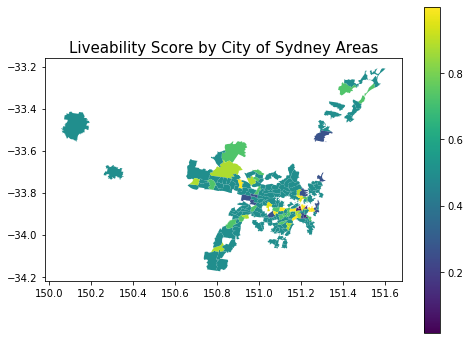

In [124]:
great = gpd.read_postgis("SELECT area_id, geom FROM nei_business_sa2", conn)
live_geod = gpd.GeoDataFrame(liveability_score, geometry = 'geom')

da_merge = great.merge(live_geod, on = 'area_id', how = 'left')
da_merge = da_merge.drop(['geom_x'],axis =1 )

a = gpd.GeoDataFrame(da_merge, geometry='geom_y')
a.plot('liveability_score', figsize=(8, 6), legend = True)
plt.title('Liveability Score by City of Sydney Areas', fontsize=15)